### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

/home/oleg_rev/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/home/oleg_rev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 28.2 s, sys: 853 ms, total: 29.1 s
Wall time: 29.1 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 45s, sys: 98.8 ms, total: 3min 45s
Wall time: 3min 45s


А теперь в 3 строчки обучим нашу модель

In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [12]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [13]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 30.2 s, sys: 24 ms, total: 30.2 s
Wall time: 30.2 s


In [14]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [15]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(6, 0.39189214),
 (9, 0.07917571),
 (13, 0.0474765),
 (14, 0.08874931),
 (17, 0.19283588),
 (23, 0.17976911)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: журнал источник nn сотрудник погибнуть область эксперимент
topic_1: топливо турция проект турецкий век германия связанный
topic_2: фонд следствие законодательство расследование корея юрист южный
topic_3: лауреат горный автобус больной терминал доходить дикий
topic_4: украина украинский восток киев остров офицер высота
topic_5: россия сша российский санкция государство глава доллар
topic_6: игра сон сократиться солнце реформа эволюция участник
topic_7: млрд научный рубль млн рост объём цена
topic_8: форум египет рекомендовать диапазон грузия альянс коллекция
topic_9: ракета поверхность американский погибнуть вскоре тыс сша
topic_10: рак статья завод кожа ст ремонт таиланд
topic_11: фестиваль иностранный мероприятие климат сайт билет программа
topic_12: экипаж рейс отряд флот вскоре подсчёт рт
topic_13: военный газ nn земля день помощь операция
topic_14: агентство применение препарат добавлять поверхность обнаружить высота
topic_15: всё ребёнок россия рынок экономика система бол

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [17]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.00000,0.0,0.0,0.0,0.025964,0.081408,0.0,0.0,...,0.000000,0.012734,0.000000,0.683527,0.188675,0.0,0.000000,0.0,0.000000,0.0
1,4896,0.177391,0.00000,0.0,0.0,0.0,0.000000,0.353842,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.445601,0.0,0.000000,0.0
2,4897,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.391968,0.0,0.0,...,0.000000,0.000000,0.192853,0.000000,0.000000,0.0,0.000000,0.0,0.179758,0.0
3,4898,0.000000,0.14231,0.0,0.0,0.0,0.000000,0.187026,0.0,0.0,...,0.270977,0.335161,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.054438,0.0
4,4899,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.099924,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.872993,0.0,0.000000,0.0,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [21]:
doc_dict[293622]

array([0.04800875, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02404431,
       0.        , 0.        , 0.        , 0.        , 0.06322407,
       0.13734564, 0.02108355, 0.        , 0.15454093, 0.10232379,
       0.        , 0.        , 0.14329576, 0.17882293, 0.11712509])

In [22]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [23]:
get_user_embedding(user_articles_list)

array([0.07298134, 0.00386851, 0.00987124, 0.        , 0.        ,
       0.17184894, 0.01881666, 0.03938271, 0.        , 0.00456135,
       0.        , 0.        , 0.00240071, 0.09977848, 0.00320444,
       0.15788983, 0.        , 0.01535934, 0.13927101, 0.04998163,
       0.04304656, 0.        , 0.03203816, 0.11310623, 0.00546887])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [24]:
#users['articles'].iloc[33]

In [25]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [26]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.074181,0.052354,0.000000,0.000000,0.057619,0.051584,0.007304,0.051837,0.003013,...,0.108335,0.008883,0.003176,0.080880,0.025215,0.039008,0.020854,0.082961,0.053137,0.037173
1,u108690,0.149801,0.012527,0.004914,0.001683,0.049225,0.134268,0.001981,0.054163,0.001765,...,0.174068,0.020570,0.000000,0.085434,0.008057,0.017802,0.012999,0.012908,0.052260,0.007040
2,u108339,0.129687,0.005850,0.009421,0.000000,0.001871,0.089022,0.006047,0.066963,0.000000,...,0.070550,0.060045,0.014439,0.125508,0.020505,0.048776,0.006504,0.014993,0.007629,0.030188


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [27]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [28]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.074181,0.052354,0.000000,0.000000,0.057619,0.051584,0.007304,0.051837,0.003013,...,0.008883,0.003176,0.080880,0.025215,0.039008,0.020854,0.082961,0.053137,0.037173,0
1,u108690,0.149801,0.012527,0.004914,0.001683,0.049225,0.134268,0.001981,0.054163,0.001765,...,0.020570,0.000000,0.085434,0.008057,0.017802,0.012999,0.012908,0.052260,0.007040,1
2,u108339,0.129687,0.005850,0.009421,0.000000,0.001871,0.089022,0.006047,0.066963,0.000000,...,0.060045,0.014439,0.125508,0.020505,0.048776,0.006504,0.014993,0.007629,0.030188,1


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=21)

In [31]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [32]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0104133 , 0.03727488, 0.11125403, 0.18243413, 0.05186281,
       0.11627704, 0.09404827, 0.10741117, 0.03847658, 0.02379264])

In [33]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.243433, F-Score=0.701, Precision=0.614, Recall=0.817


In [35]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1637  123]
 [  45  195]]


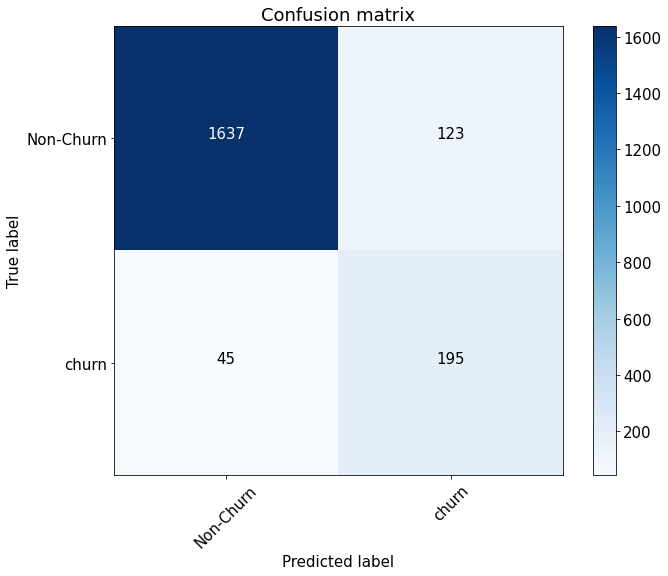

In [36]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

roc auc на np.mean

In [37]:
roc_auc_score(y_test, preds)

0.9504190340909092

In [38]:
mean_score = {"mean":pd.Series([thresholds[ix],
                               fscore[ix],
                               precision[ix],
                               recall[ix],
                               roc_auc_score(y_test, preds)],
                               index=['Threshold',
                                      'F-Score',
                                      'Precision',
                                      'Recall',
                                      'ROC_AUC'])}
df_score = pd.DataFrame(mean_score)

In [39]:
df_score

,mean
Threshold,0.243433
F-Score,0.701252
Precision,0.614420
Recall,0.816667
ROC_AUC,0.950419


В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)


4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.


### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [40]:
def get_user_embedding(user_articles_list, agg_func=np.mean):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = agg_func(user_vector, 0)
    return user_vector

In [41]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np.median), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.024004,0.006038,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.068673,0.000000,0.000000,0.023868,0.000000,0.000000,0.0,0.050940,0.029545,0.016232
1,u108690,0.149511,0.000000,0.0,0.0,0.029917,0.095768,0.0,0.044889,0.0,...,0.201776,0.011352,0.000000,0.064143,0.000000,0.006839,0.0,0.011175,0.049641,0.000000
2,u108339,0.119346,0.000000,0.0,0.0,0.000000,0.063142,0.0,0.052386,0.0,...,0.069130,0.049513,0.007953,0.097873,0.006255,0.019364,0.0,0.005867,0.000000,0.033467


In [42]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.024004,0.006038,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.023868,0.000000,0.000000,0.0,0.050940,0.029545,0.016232,0
1,u108690,0.149511,0.000000,0.0,0.0,0.029917,0.095768,0.0,0.044889,0.0,...,0.011352,0.000000,0.064143,0.000000,0.006839,0.0,0.011175,0.049641,0.000000,1
2,u108339,0.119346,0.000000,0.0,0.0,0.000000,0.063142,0.0,0.052386,0.0,...,0.049513,0.007953,0.097873,0.006255,0.019364,0.0,0.005867,0.000000,0.033467,1


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=21)

In [44]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [45]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.01261607, 0.02096907, 0.07508412, 0.16154073, 0.02241488,
       0.12268278, 0.0235521 , 0.12060717, 0.0090223 , 0.02005787])

In [46]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix], 
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

Best Threshold=0.281114, F-Score=0.716, Precision=0.663, Recall=0.779


Confusion matrix, without normalization
[[1606  154]
 [  29  211]]


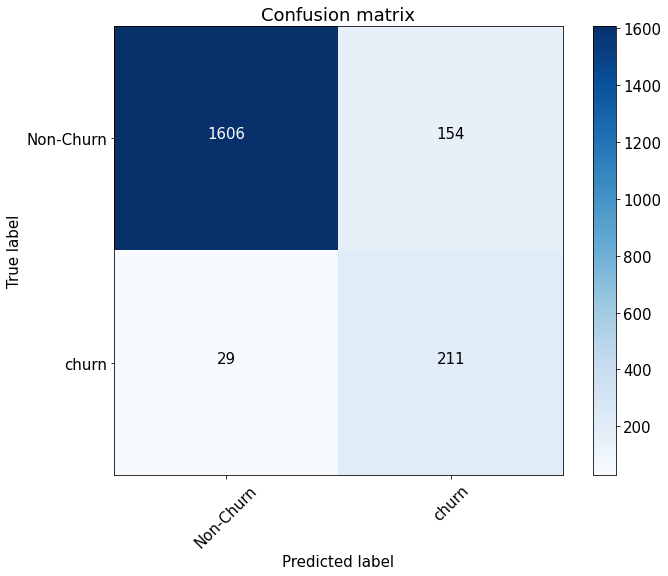

In [47]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

roc auc на np.median

In [48]:
roc_auc_score(y_test, preds)

0.9590719696969696

In [49]:
median_score = {"median": pd.Series([thresholds_median[ix],
                                     fscore_median[ix],
                                     precision_median[ix],
                                     recall_median[ix],
                                     roc_auc_score(y_test, preds)],
                                    index=['Threshold',
                                           'F-Score',
                                           'Precision',
                                           'Recall',
                                           'ROC_AUC'])}


In [50]:
df_score = df_score.join(pd.DataFrame(median_score))
df_score

,mean,median
Threshold,0.243433,0.281114
F-Score,0.701252,0.716475
Precision,0.614420,0.663121
Recall,0.816667,0.779167
ROC_AUC,0.950419,0.959072


### 3. Повторить п.2, но используя уже не медиану, а max

In [51]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np.max), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.297652,0.168306,0.000000,0.000000,0.345716,0.194293,0.043822,0.232645,0.018077,...,0.259401,0.032217,0.019053,0.283002,0.102324,0.150128,0.062770,0.252589,0.178823,0.117125
1,u108690,0.268320,0.052601,0.029482,0.010095,0.138045,0.383154,0.011886,0.120856,0.010591,...,0.330403,0.076040,0.000000,0.239763,0.029276,0.074882,0.077992,0.032375,0.159489,0.042237
2,u108339,0.258757,0.023018,0.035555,0.000000,0.011227,0.253207,0.036281,0.172523,0.000000,...,0.109278,0.148480,0.046932,0.295633,0.075455,0.153089,0.021929,0.046697,0.033176,0.059974


In [52]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.297652,0.168306,0.000000,0.000000,0.345716,0.194293,0.043822,0.232645,0.018077,...,0.032217,0.019053,0.283002,0.102324,0.150128,0.062770,0.252589,0.178823,0.117125,0
1,u108690,0.268320,0.052601,0.029482,0.010095,0.138045,0.383154,0.011886,0.120856,0.010591,...,0.076040,0.000000,0.239763,0.029276,0.074882,0.077992,0.032375,0.159489,0.042237,1
2,u108339,0.258757,0.023018,0.035555,0.000000,0.011227,0.253207,0.036281,0.172523,0.000000,...,0.148480,0.046932,0.295633,0.075455,0.153089,0.021929,0.046697,0.033176,0.059974,1


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=21)

In [54]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [55]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.00089118, 0.00225809, 0.01449193, 0.27990904, 0.03348076,
       0.08140906, 0.00637514, 0.0166354 , 0.00348002, 0.00379047])

In [56]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix], 
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

Best Threshold=0.387968, F-Score=0.834, Precision=0.862, Recall=0.808


Confusion matrix, without normalization
[[1683   77]
 [  28  212]]


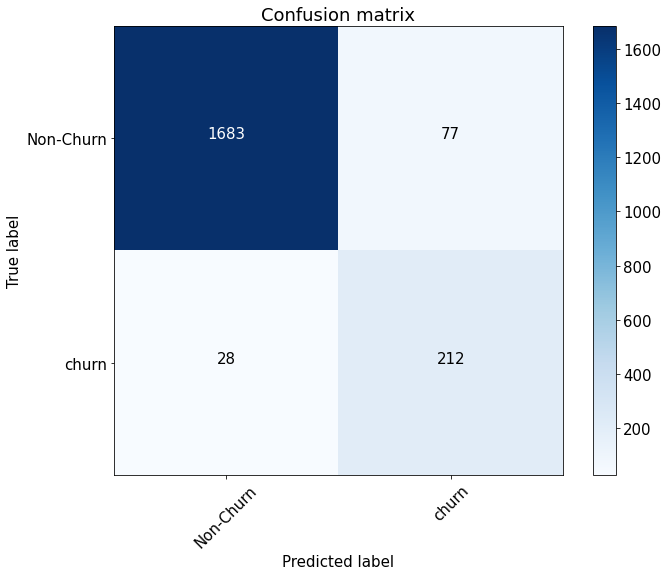

In [57]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [58]:
roc_auc_score(y_test, preds)

0.9797466856060606

In [59]:
max_score = {"max": pd.Series([thresholds_max[ix],
                               fscore_max[ix],
                               precision_max[ix],
                               recall_max[ix],
                               roc_auc_score(y_test, preds)],
                              index=['Threshold',
                                     'F-Score',
                                     'Precision',
                                     'Recall',
                                     'ROC_AUC'])}


In [60]:
df_score = df_score.join(pd.DataFrame(max_score))
df_score

,mean,median,max
Threshold,0.243433,0.281114,0.387968
F-Score,0.701252,0.716475,0.834409
Precision,0.614420,0.663121,0.862222
Recall,0.816667,0.779167,0.808333
ROC_AUC,0.950419,0.959072,0.979747


### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score


In [61]:
df_score

,mean,median,max
Threshold,0.243433,0.281114,0.387968
F-Score,0.701252,0.716475,0.834409
Precision,0.614420,0.663121,0.862222
Recall,0.816667,0.779167,0.808333
ROC_AUC,0.950419,0.959072,0.979747


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk